In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
ibmqfactory.load_account:WARNING:2023-08-17 13:53:55,257: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n)])


def effective_hem(size, J):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        hem[i, i] = h(size, J, Z)
    return hem

In [6]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = 128
#shots = np.arange(10, 2000, 100)
shots = [2**i for i in range(7, 12)]
delay = np.linspace(0, 2 * np.pi, measurements)
repetitions = 4
for n in range(2, 6):  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.4) for _ in range(n)]
            delay_list = []
            for t in delay:
                delay_list.append(RamseyExperiment(n, t, s // measurements, J, f'J = {J} CosineFit n = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)

        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots


    exp.append(shot_list)


5
5
5


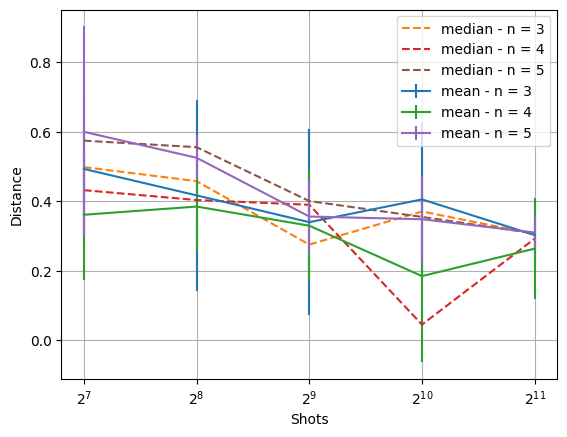

In [7]:
%matplotlib inline

plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    print(len(dist["mean"]))
    plt.errorbar(shots, dist["mean"],yerr=dist["std"], linestyle='-',  label=f'mean - n = {str(i + 2)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - n = {str(i + 2)}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points

In [9]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2**i for i in range(7, 10)]
shots = [2**i for i in range(7, 12)]
#shots = [500]
repetitions = 20
for n in measurements:  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(4)]
            delay_list = []
            delay = np.linspace(0, 2 * np.pi, n)
            for t in delay:
                delay_list.append(RamseyExperiment(4, t, s // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)
        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots


    exp.append(shot_list)



QiskitError: 'No counts for experiment "0"'

In [ ]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    plt.errorbar(shots, dist["mean"],yerr=dist["std"], linestyle='-',  label=f'mean - measurement points = {str(measurements[i])}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - measurement points = {str(measurements[i])}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points and fixed number of shots

In [11]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2**i for i in range(4, 10)]
shots = 2048
repetitions = 20
shot_list = {}
median_dist_for_shots = []
mean_dist_for_shots = []
std_dist_for_shots = []
for n in measurements:  #qubits

    rep_list = []
    for rep in range(repetitions):
        J = [random.gauss(1, 0.1) for _ in range(4)]
        delay_list = []
        delay = np.linspace(0, 2 * np.pi, n)
        for t in delay:
            delay_list.append(RamseyExperiment(4, t, shots // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
        ramseyBatch = RamseyBatch(delay_list)
        rep_list.append(ramseyBatch)
    median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
    mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
    std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

shot_list["mean"] = mean_dist_for_shots
shot_list["std"] = std_dist_for_shots
shot_list["median"] = median_dist_for_shots

exp.append(shot_list)



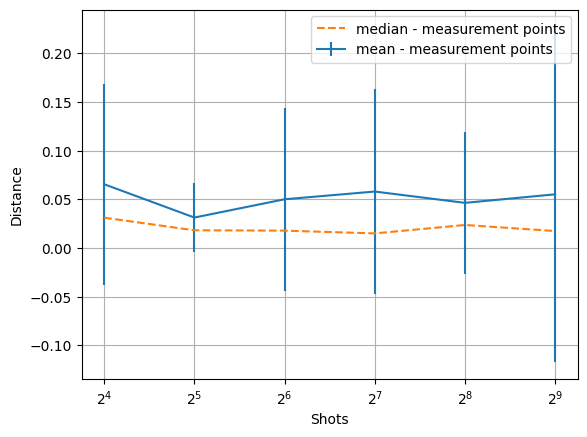

In [12]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
dist = shot_list
plt.errorbar(measurements, dist["mean"],yerr=dist["std"], linestyle='-',  label=f'mean - measurement points')
plt.plot(measurements, dist["median"], linestyle='--', label=f'median - measurement points')

plt.xscale('log', base=2)
plt.legend()

In [9]:
import random
import importlib
import ramsey_experiment
ramsey_experiment=importlib.reload(ramsey_experiment)
RamseyExperiment=ramsey_experiment.RamseyExperiment
RamseyBatch=ramsey_experiment.RamseyBatch

n = 3
def func(t, js):
    n = len(js)
    result = 2*n
    for i in range(n):
        result += 4 * np.cos(4 * js[i] * t)
    for i in range(n):
        result += 2*np.cos(4 * (js[i] + js[(i + 1) % n]) * t)
    return result / (2 ** (n-(n-3)))


delay_list = []
exp = []
measurements = 100
delay = np.linspace(0,2*np.pi,measurements)
J = [random.gauss(1, 0.3) for _ in range(n)]
for t in delay:
    delay_list.append(RamseyExperiment(n, t, 100, J, "3"))
ramseyBatch = RamseyBatch(delay_list)

print(J)
print(ramseyBatch.J_fit)
print(ramseyBatch.RamseyExperiments[0].z)
#print(ramseyBatch.Z)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
plt.title(f'J = {J}')
plt.plot(delay,ramseyBatch.Z, label = 'Simulation')

from scipy.ndimage import gaussian_filter

#smoothed_data = gaussian_filter(ramseyBatch.Z, sigma=1)

#plt.plot(delay,smoothed_data, label = 'smoothed simulation')

plt.plot(delay,[func(t,J) for t in delay], label = 'fit')
plt.plot(delay,[func(t,ramseyBatch.J_fit) for t in delay], label = 'Found J')

plt.legend()

ibmqfactory.load_account:WARNING:2023-08-17 14:17:58,328: Credentials are already in use. The existing account in the session will be replaced.


[0.0, 0.06346651825433926, 0.12693303650867852, 0.1903995547630178, 0.25386607301735703, 0.3173325912716963, 0.3807991095260356, 0.4442656277803748, 0.5077321460347141, 0.5711986642890533, 0.6346651825433925, 0.6981317007977318, 0.7615982190520711, 0.8250647373064104, 0.8885312555607496, 0.9519977738150889, 1.0154642920694281, 1.0789308103237674, 1.1423973285781066, 1.2058638468324459, 1.269330365086785, 1.3327968833411243, 1.3962634015954636, 1.4597299198498028, 1.5231964381041423, 1.5866629563584815, 1.6501294746128208, 1.71359599286716, 1.7770625111214993, 1.8405290293758385, 1.9039955476301778, 1.967462065884517, 2.0309285841388562, 2.0943951023931957, 2.1578616206475347, 2.221328138901874, 2.284794657156213, 2.3482611754105527, 2.4117276936648917, 2.475194211919231, 2.53866073017357, 2.6021272484279097, 2.6655937666822487, 2.729060284936588, 2.792526803190927, 2.8559933214452666, 2.9194598396996057, 2.982926357953945, 3.0463928762082846, 3.1098593944626236, 3.173325912716963, 3.23

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

[6.684507609859604, 5.570423008216336, 2.0690142601946393, 1.591549430918953, 0.31830988618379064, 1.2732395447351625, 0.6366197723675813]


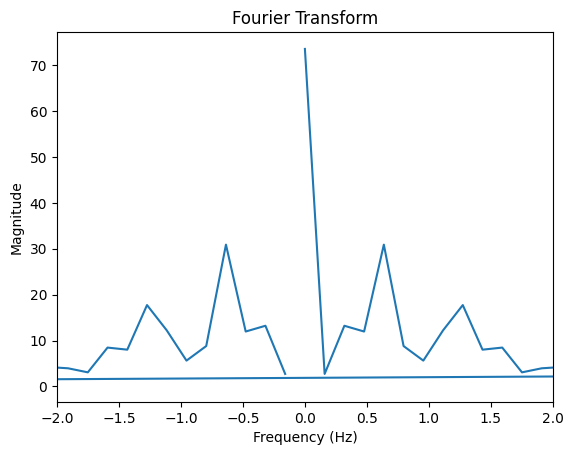

In [42]:
from scipy.signal import find_peaks

fft_output = np.fft.fft(ramseyBatch.Z)
# Compute the corresponding frequencies
sample_rate = measurements/(2*np.pi)  # Sampling rate of your data (change if known)
frequencies = np.fft.fftfreq(len(ramseyBatch.Z), 1/sample_rate)

# Compute the magnitude (absolute value) of the Fourier Transform
magnitude = np.abs(fft_output)
peaks, _ = find_peaks(magnitude, height=2) # Set an appropriate threshold
sorted_peaks = np.argsort(magnitude[peaks])[-14:]
peak_frequencies = frequencies[peaks[sorted_peaks]]
peak_frequencies = [freq for freq in peak_frequencies if freq > 0]

print(peak_frequencies)
# Plot the magnitude of the Fourier Transform
plt.plot(frequencies, magnitude)
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-2, 2)
plt.show()